# Дипломный проект - обучение модели и выбор оптимального алгоритма


## Прогнозирование стоимости квартир на побережье Черного моря

Описание:
Нам поставлена задача создать модель, которая будет предсказывать стоимость квартир на Черноморском побережье.
Если наша модель работает хорошо, то мы сможем быстро выявлять выгодные предложения (когда желаемая цена продавца ниже предсказанной рыночной цены).

Датасет был получен при помощи парсинга сайта cian.ru и обработан на этапе EDA.

В данном ноутбуке мы сделаем следующее:
* Обработаем и отнормируем признаки
* Построим "наивную"/baseline модель, предсказывающую цену по общей площади и городу (с ней будем сравнивать другие модели)
* Построим модель при помощи логистической регрессии
* Построим модель при помощи линейной регрессии
* Обучим модель на основе случайного леса
* Сделаем  модель на основе градиентного бустинга с помощью CatBoost
* Применим кросс-валидацию для градиетного бустинга
* На основе предыдущих шагов выберем оптимальную модель

# Загрузка библиотек

In [87]:
#!pip install catboost

In [88]:
#!pip install optuna

In [89]:
import random
import numpy as np 
import pandas as pd 
import sys
import optuna

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm

# plt
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

In [90]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.8.3 (default, Jul  2 2020, 16:21:59) 
Numpy        : 1.18.5


In [91]:
!pip freeze > requirements.txt

# Настройки

In [92]:
# зафиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы
RANDOM_SEED = 42

TEST_SIZE = 0.2

# Вспомогательные функции

In [93]:
# напишем функцию для расчета mape
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

# Загружаем данные

In [94]:
df = pd.read_csv('cian_eda.csv')

In [95]:
df.head()

,newBuilding,flatType,floorNumber,fromDeveloper,fullUrl,isApartments,isAuction,kitchenArea,livingArea,roomsCount,...,cargoLiftsCount,materialType,hasBalcony,isBasement,isFirstFloor,isLastFloor,cityPopulation,cityArea,populationDensity,areaPerRoom
0,0,rooms,2,False,https://krym.cian.ru/sale/flat/246745649/,False,True,10.413152,26.000000,1,...,0,monolithBrick,1,0,0,0,79056,18.2,4343.736264,54.40
1,1,rooms,7,True,https://krym.cian.ru/sale/flat/245655396/,False,True,8.093163,24.327497,1,...,0,monolith,0,0,0,0,79056,18.2,4343.736264,42.28
2,1,rooms,6,True,https://krym.cian.ru/sale/flat/247658165/,True,True,10.126025,30.438141,1,...,0,monolith,0,0,0,0,79056,18.2,4343.736264,52.90
3,0,rooms,2,False,https://krym.cian.ru/sale/flat/240865470/,True,True,10.000000,13.809365,1,...,0,monolith,1,0,0,0,79056,18.2,4343.736264,24.00
4,0,rooms,3,False,https://krym.cian.ru/sale/flat/236164313/,False,True,8.613821,25.892559,1,...,1,monolith,1,0,0,0,79056,18.2,4343.736264,45.00


# Предобработка данных

In [96]:
# Составим список бинарных категориальных признаков:
bin_features = [
    'newBuilding',
    'fromDeveloper',
    'isApartments',
    'isAuction',
    'isComplete',
    'hasBalcony',
    'isBasement',
    'isFirstFloor',
    'isLastFloor',
    'passengerLiftsCount',
    'cargoLiftsCount',
]

# Составим список категориальных признаков:
cat_features = [
    'flatType',
    'region',
    'city',
    'materialType',
]
 
# Составим список числовых признаков:
num_features = [
    'floorNumber',
    'kitchenArea',
    'livingArea',
    'roomsCount',
    'totalArea',
    'floorsCount',
    'cityPopulation',
    'cityArea',
    'populationDensity',
    'areaPerRoom',
]

In [97]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df.copy()
    df_output = df_output.drop(['fullUrl'], axis=1)
 
    # Нормализация данных и логорифмирование
    scaler = MinMaxScaler()
    for column in num_features:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]
        # логорифмирование ухудшило результат
        # df_output[column] = np.log(df_output[column])
        
    # ################### Categorical Features ############################################################## 
      
    # # Label Encoding
    for column in bin_features:
        df_output[column] = df_output[column].astype('category').cat.codes
        
    # # One-Hot Encoding:
    df_output = pd.get_dummies(df_output, columns=cat_features, dummy_na=False)
    
    return df_output

In [98]:
# Запускаем и проверяем, что получилось
df_preproc = preproc_data(df)
df_preproc.sample(10)

,newBuilding,floorNumber,fromDeveloper,isApartments,isAuction,kitchenArea,livingArea,roomsCount,totalArea,price,...,materialType_foamConcreteBlock,materialType_gasSilicateBlock,materialType_monolith,materialType_monolithBrick,materialType_old,materialType_panel,materialType_stalin,materialType_unknown,materialType_wireframe,materialType_wood
15239,0,0.041667,0,0,0,0.374587,0.085593,0.0,0.246218,5800000,...,0,0,1,0,0,0,0,0,0,0
30574,0,0.166667,0,0,0,0.102310,0.382203,0.4,0.502521,4000000,...,0,0,0,0,0,0,0,0,0,0
22797,0,0.125000,0,0,0,0.082508,0.244068,0.2,0.295798,2100000,...,0,0,0,0,0,0,0,0,0,0
21791,0,0.041667,0,0,0,0.082508,0.271186,0.2,0.319328,3250000,...,0,0,0,0,0,0,0,0,0,0
29575,0,0.291667,0,0,0,0.173021,0.284097,0.2,0.420168,7000000,...,0,0,0,0,0,0,0,1,0,0
14952,1,0.250000,0,0,0,0.154069,0.254840,0.0,0.369748,6500000,...,0,0,1,0,0,0,0,0,0,0
8153,0,0.333333,0,0,0,0.236196,0.381620,0.4,0.588235,7900000,...,0,0,0,0,0,0,0,0,0,0
30270,0,0.083333,0,0,0,0.313531,0.203390,0.2,0.457143,7000000,...,0,0,0,0,0,0,0,1,0,0
680,0,0.083333,0,0,0,0.169863,0.279221,0.2,0.411765,4400000,...,0,0,0,0,0,0,0,0,0,0
28921,0,0.166667,0,0,0,0.123762,0.245763,0.2,0.361345,6800000,...,0,0,0,0,0,1,0,0,0,0


In [99]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31511 entries, 0 to 31510
Data columns (total 61 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   newBuilding                     31511 non-null  int8   
 1   floorNumber                     31511 non-null  float64
 2   fromDeveloper                   31511 non-null  int8   
 3   isApartments                    31511 non-null  int8   
 4   isAuction                       31511 non-null  int8   
 5   kitchenArea                     31511 non-null  float64
 6   livingArea                      31511 non-null  float64
 7   roomsCount                      31511 non-null  float64
 8   totalArea                       31511 non-null  float64
 9   price                           31511 non-null  int64  
 10  floorsCount                     31511 non-null  float64
 11  isComplete                      31511 non-null  int8   
 12  passengerLiftsCount             

## Split Data

In [100]:
y = df_preproc.price.values
X = df_preproc.drop(['price'], axis=1)

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, shuffle=True, random_state=RANDOM_SEED)

# Обучение модели

## Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю стоимость квартиры по общей площади и городу. 
C ней будем сравнивать другие модели.



In [102]:
# split данных для наивной модели
data_train, data_test = train_test_split(df, test_size=TEST_SIZE, shuffle=True, random_state=RANDOM_SEED)

# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['totalArea', 'city']]).iterrows():
    query = f"totalArea == '{row[0]}' and city == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 22.86%


## Model 2: LogisticRegression

In [103]:
# model = LogisticRegression(solver='saga', max_iter=200, n_jobs=-1)
# # Обучаем модель на тестовом наборе данных
# model.fit(X_train, y_train)

In [104]:
# test_predict_LR = model.predict(X_test)
# print(f"TEST mape: {(mape(y_test, test_predict_LR))*100:0.2f}%")

TEST mape: 23.36

Логистическая регрессия работает долго на нашем датасете и показывает результаты хуже чем у наивной модели.

## Model 2: LinearRegression

Попробуем обучить модель при помощи линейной без логорифмирования призноков.

In [105]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [106]:
test_predict_LR = lr.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_LR))*100:0.2f}%")

TEST mape: 21.26%


Теперь обучим модель при помощи линейной с логорифмированием целевой переменной

In [107]:
regr = TransformedTargetRegressor(regressor=lr, func=np.log, inverse_func=np.exp)

In [108]:
regr.fit(X_train, y_train)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=LinearRegression())

In [109]:
test_predict_LR_log = regr.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_LR_log))*100:0.2f}%")

TEST mape: 19.69%


Результат улучшился

## Model 3: RandomForestRegressor

Аналогично для случайного леса - сначала обучим модель без логорифмирования целевой переменной

In [110]:
rf = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [111]:
# Обучаем модель на тестовом наборе данных
rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.2s finished


RandomForestRegressor(n_jobs=-1, random_state=42, verbose=1)

In [112]:
test_predict_RFR = rf.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_RFR))*100:0.2f}%")

TEST mape: 15.79%


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


Случайный лес работает очень быстро и показывает приемлемые результаты.

Теперь прологорифмируем таргет

In [113]:
regr = TransformedTargetRegressor(regressor=rf, func=np.log, inverse_func=np.exp)

In [114]:
regr.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.0s finished


TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=RandomForestRegressor(n_jobs=-1,
                                                           random_state=42,
                                                           verbose=1))

In [115]:
test_predict_RFR_log = regr.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_RFR_log))*100:0.2f}%")

TEST mape: 15.14%


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


Видим, что с логорифмированием результат улучшился

Попробуем отобрать признаки при помощи встроенной в RandomForest функции

In [116]:
plt.rcParams['figure.figsize'] = (7,12)

Text(0.5, 0, 'Random Forest Feature Importance')

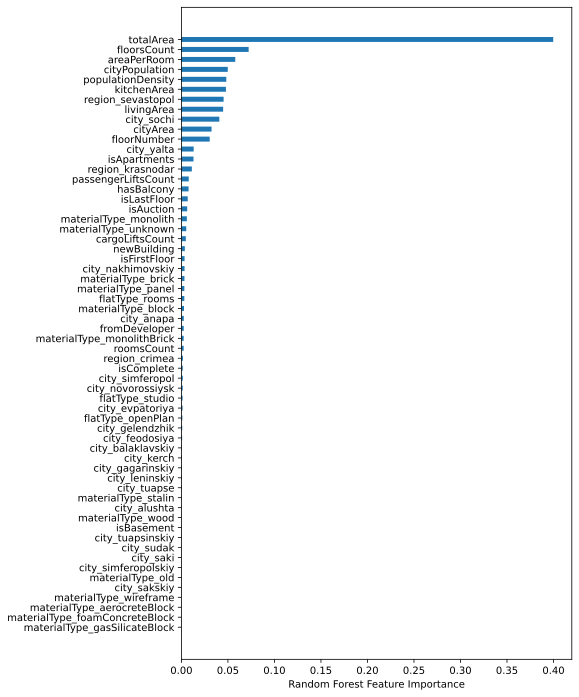

In [117]:
sorted_idx = rf.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], rf.feature_importances_[sorted_idx], height=0.5)
plt.xlabel("Random Forest Feature Importance")

Попробуем оставить только 11 самых значимых признаков и заново обучить модель

In [118]:
X_train_fi = X_train[[
    'totalArea',
    'floorsCount',
    'areaPerRoom',
    'cityPopulation',
    'populationDensity',
    'kitchenArea',
    'region_sevastopol',
    'livingArea',
    'city_sochi',
    'cityArea',
    'floorNumber',
]]
X_test_fi = X_test[[
    'totalArea',
    'floorsCount',
    'areaPerRoom',
    'cityPopulation',
    'populationDensity',
    'kitchenArea',
    'region_sevastopol',
    'livingArea',
    'city_sochi',
    'cityArea',
    'floorNumber',
]]

In [119]:
# Обучаем модель на тестовом наборе данных
rf.fit(X_train_fi, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.1s finished


RandomForestRegressor(n_jobs=-1, random_state=42, verbose=1)

In [120]:
test_predict_RFR = rf.predict(X_test_fi)
print(f"TEST mape: {(mape(y_test, test_predict_RFR))*100:0.2f}%")

TEST mape: 16.50%


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


Результат ухудшился. Попробуем с логорифмированием таргета.

In [121]:
regr.fit(X_train_fi, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.9s finished


TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=RandomForestRegressor(n_jobs=-1,
                                                           random_state=42,
                                                           verbose=1))

In [122]:
test_predict_RFR_log = regr.predict(X_test_fi)
print(f"TEST mape: {(mape(y_test, test_predict_RFR_log))*100:0.2f}%")

TEST mape: 15.74%


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


Видим, что отбор признаков ухудшил результат

Попробуем подобрать гиперпараметры модели при помощи модуля optuna

In [123]:
def objective(trial):

    rf_n_estimators = trial.suggest_int("rf_n_estimators", 10, 200)
    rf_max_depth = trial.suggest_int("rf_max_depth", 5, 10, log=True)
    classifier_obj = RandomForestRegressor(
        max_depth=rf_max_depth,
        n_estimators=rf_n_estimators,
        random_state=RANDOM_SEED,
    )
    regr = TransformedTargetRegressor(regressor=classifier_obj, func=np.log, inverse_func=np.exp)
    
    regr.fit(X_train, y_train)

    test_predict = regr.predict(X_test)
    
    return mape(y_test, test_predict)

# Step 4: Running it
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=8)

[I 2021-02-04 00:28:17,619] A new study created in memory with name: no-name-7f8b0017-e514-410a-86bd-10a71d3dae96
[I 2021-02-04 00:28:26,915] Trial 0 finished with value: 0.213429966941524 and parameters: {'rf_n_estimators': 180, 'rf_max_depth': 5}. Best is trial 0 with value: 0.213429966941524.
[I 2021-02-04 00:28:29,868] Trial 1 finished with value: 0.19920151085903504 and parameters: {'rf_n_estimators': 48, 'rf_max_depth': 6}. Best is trial 1 with value: 0.19920151085903504.
[I 2021-02-04 00:28:40,809] Trial 2 finished with value: 0.18801158992844708 and parameters: {'rf_n_estimators': 157, 'rf_max_depth': 7}. Best is trial 2 with value: 0.18801158992844708.
[I 2021-02-04 00:28:42,743] Trial 3 finished with value: 0.21358788461868344 and parameters: {'rf_n_estimators': 37, 'rf_max_depth': 5}. Best is trial 2 with value: 0.18801158992844708.
[I 2021-02-04 00:28:48,099] Trial 4 finished with value: 0.2135489941495176 and parameters: {'rf_n_estimators': 103, 'rf_max_depth': 5}. Best is

Лучше не стало. Можно и дальше подбирать параметры, но мы сейчас не будем этим заниматься

## Model 4: CatBoostRegressor

Обучим модель на основе catboost, предварительно настроим параметры для получения наилучшего результата.

In [124]:
cb = CatBoostRegressor(iterations = 7000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                         )
cb.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         )

Learning rate set to 0.025228
0:	learn: 0.4497708	test: 0.4368527	best: 0.4368527 (0)	total: 7.64ms	remaining: 53.5s
100:	learn: 0.2250789	test: 0.2169627	best: 0.2169627 (100)	total: 734ms	remaining: 50.1s
200:	learn: 0.1978495	test: 0.1918068	best: 0.1918068 (200)	total: 1.39s	remaining: 46.9s
300:	learn: 0.1885902	test: 0.1841315	best: 0.1841315 (300)	total: 2.45s	remaining: 54.6s
400:	learn: 0.1836817	test: 0.1804815	best: 0.1804815 (400)	total: 3.23s	remaining: 53.2s
500:	learn: 0.1802599	test: 0.1782553	best: 0.1782553 (500)	total: 4.03s	remaining: 52.3s
600:	learn: 0.1776783	test: 0.1766353	best: 0.1766353 (600)	total: 5.29s	remaining: 56.3s
700:	learn: 0.1756089	test: 0.1753943	best: 0.1753943 (700)	total: 6.08s	remaining: 54.6s
800:	learn: 0.1738609	test: 0.1744265	best: 0.1744265 (800)	total: 6.71s	remaining: 51.9s
900:	learn: 0.1722785	test: 0.1736884	best: 0.1736884 (900)	total: 7.5s	remaining: 50.8s
1000:	learn: 0.1706673	test: 0.1729355	best: 0.1729355 (1000)	total: 8.18s

In [125]:
test_predict_catboost = cb.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")

TEST mape: 16.52%


Посмотрим, какие фичи CatBoost считает наиболее важными

Text(0.5, 0, 'Random Forest Feature Importance')

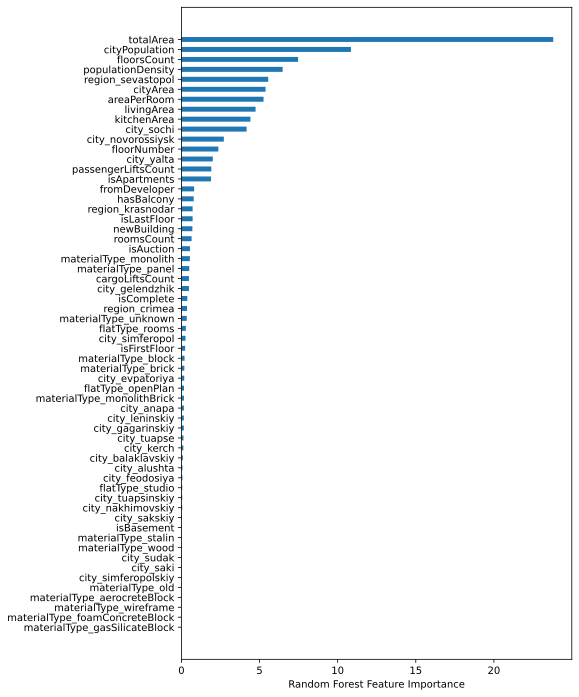

In [126]:
sorted_idx = cb.get_feature_importance(data=None,
                       prettified=False,
                       thread_count=-1,
                       verbose=False).argsort()
plt.barh(X.columns[sorted_idx], cb.feature_importances_[sorted_idx], height=0.5)
plt.xlabel("Random Forest Feature Importance")

Catboost показал результаты хуже чем RandomForest

Эксперименты показали, что отбор признаков не улучшил результат

## Model 5: Catboost CV

Организуем обучение модели на 5 фолдах, с дальнейшим объединением предсказаний от каждой модели.

In [127]:
def cat_model(y_train, X_train, X_test, y_test):
    model = CatBoostRegressor(iterations = 7000,
                              #depth=12,
                              #learning_rate = 0.02,
                              random_seed = RANDOM_SEED,
                              eval_metric='MAPE',
                              custom_metric=['RMSE', 'MAE'],
                              od_wait=500,
                              #task_type='GPU',
                            )
    model.fit(X_train, y_train,
            eval_set=(X_test, y_test),
            verbose_eval=100,
            use_best_model=True
            )
    
    return(model)

In [128]:
submissions = pd.DataFrame(0,columns=["sub_1"],index=df.index) # в submissions пишем предикты по каждой модели
score_ls = []
splits = list(KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED).split(X, y))

for idx, (train_idx, test_idx) in tqdm(enumerate(splits), total=5,):
    # use the indexes to extract the folds in the train and validation data
    X_train, y_train, X_test, y_test = X.iloc[train_idx], y[train_idx], X.iloc[test_idx], y[test_idx]
    # model for this fold
    model = cat_model(y_train, X_train, X_test, y_test,)
    # score model on test
    test_predict = model.predict(X_test)
    test_score = mape(y_test, test_predict)
    score_ls.append(test_score)
    print(f"{idx+1} Fold Test MAPE: {mape(y_test, test_predict):0.3f}")
    # submissions
    submissions[f'sub_{idx+1}'] = model.predict(X)
    model.save_model(f'catboost_fold_{idx+1}.model')
    
print(f'Mean Score: {np.mean(score_ls):0.3f}')
print(f'Std Score: {np.std(score_ls):0.4f}')
print(f'Max Score: {np.max(score_ls):0.3f}')
print(f'Min Score: {np.min(score_ls):0.3f}')

Learning rate set to 0.025228
0:	learn: 0.4497708	test: 0.4368527	best: 0.4368527 (0)	total: 5.7ms	remaining: 39.9s
100:	learn: 0.2250068	test: 0.2168334	best: 0.2168334 (100)	total: 785ms	remaining: 53.6s
200:	learn: 0.1977849	test: 0.1915271	best: 0.1915271 (200)	total: 1.57s	remaining: 53s
300:	learn: 0.1885986	test: 0.1838189	best: 0.1838189 (300)	total: 3.16s	remaining: 1m 10s
400:	learn: 0.1837310	test: 0.1803067	best: 0.1803067 (400)	total: 4.12s	remaining: 1m 7s
500:	learn: 0.1802452	test: 0.1778137	best: 0.1778137 (500)	total: 4.85s	remaining: 1m 2s
600:	learn: 0.1777757	test: 0.1762760	best: 0.1762760 (600)	total: 5.52s	remaining: 58.8s
700:	learn: 0.1756337	test: 0.1750520	best: 0.1750500 (699)	total: 6.29s	remaining: 56.5s
800:	learn: 0.1737749	test: 0.1741632	best: 0.1741555 (798)	total: 7.05s	remaining: 54.6s
900:	learn: 0.1722305	test: 0.1735301	best: 0.1735301 (900)	total: 7.82s	remaining: 52.9s
1000:	learn: 0.1707879	test: 0.1728844	best: 0.1728844 (1000)	total: 8.59s	

1800:	learn: 0.1594304	test: 0.1760806	best: 0.1760806 (1800)	total: 14.1s	remaining: 40.7s
1900:	learn: 0.1584356	test: 0.1756490	best: 0.1756490 (1900)	total: 14.9s	remaining: 39.9s
2000:	learn: 0.1575710	test: 0.1753844	best: 0.1753806 (1999)	total: 15.8s	remaining: 39.5s
2100:	learn: 0.1566103	test: 0.1750389	best: 0.1750389 (2100)	total: 16.7s	remaining: 38.8s
2200:	learn: 0.1557505	test: 0.1747587	best: 0.1747587 (2200)	total: 17.4s	remaining: 38s
2300:	learn: 0.1549699	test: 0.1745004	best: 0.1745004 (2300)	total: 18.6s	remaining: 38s
2400:	learn: 0.1541483	test: 0.1741918	best: 0.1741918 (2400)	total: 20.4s	remaining: 39s
2500:	learn: 0.1534060	test: 0.1739051	best: 0.1739051 (2500)	total: 21.3s	remaining: 38.3s
2600:	learn: 0.1526713	test: 0.1736164	best: 0.1736164 (2600)	total: 22.2s	remaining: 37.6s
2700:	learn: 0.1519807	test: 0.1733959	best: 0.1733959 (2700)	total: 23.8s	remaining: 37.9s
2800:	learn: 0.1513170	test: 0.1732046	best: 0.1732031 (2798)	total: 24.7s	remaining: 

3600:	learn: 0.1462707	test: 0.1692504	best: 0.1692437 (3589)	total: 32.5s	remaining: 30.7s
3700:	learn: 0.1457123	test: 0.1691588	best: 0.1691506 (3663)	total: 33.2s	remaining: 29.6s
3800:	learn: 0.1451798	test: 0.1690550	best: 0.1690430 (3793)	total: 34.1s	remaining: 28.7s
3900:	learn: 0.1446333	test: 0.1688778	best: 0.1688778 (3900)	total: 34.8s	remaining: 27.7s
4000:	learn: 0.1441258	test: 0.1687469	best: 0.1687413 (3996)	total: 35.6s	remaining: 26.7s
4100:	learn: 0.1435657	test: 0.1686392	best: 0.1686392 (4100)	total: 36.6s	remaining: 25.9s
4200:	learn: 0.1430252	test: 0.1685727	best: 0.1685605 (4194)	total: 37.4s	remaining: 24.9s
4300:	learn: 0.1424905	test: 0.1684410	best: 0.1684360 (4295)	total: 38.3s	remaining: 24s
4400:	learn: 0.1419754	test: 0.1683501	best: 0.1683501 (4400)	total: 39.8s	remaining: 23.5s
4500:	learn: 0.1414733	test: 0.1682320	best: 0.1682320 (4500)	total: 41.6s	remaining: 23.1s
4600:	learn: 0.1409843	test: 0.1681400	best: 0.1681400 (4600)	total: 42.3s	remaini

5400:	learn: 0.1384082	test: 0.1671065	best: 0.1671065 (5400)	total: 46.2s	remaining: 13.7s
5500:	learn: 0.1379338	test: 0.1669979	best: 0.1669979 (5500)	total: 47.5s	remaining: 12.9s
5600:	learn: 0.1374891	test: 0.1669227	best: 0.1669221 (5598)	total: 48.8s	remaining: 12.2s
5700:	learn: 0.1370684	test: 0.1668569	best: 0.1668567 (5699)	total: 49.6s	remaining: 11.3s
5800:	learn: 0.1366559	test: 0.1667811	best: 0.1667802 (5798)	total: 51s	remaining: 10.5s
5900:	learn: 0.1362035	test: 0.1667338	best: 0.1667243 (5889)	total: 52.7s	remaining: 9.82s
6000:	learn: 0.1357583	test: 0.1666490	best: 0.1666432 (5991)	total: 54.1s	remaining: 9.01s
6100:	learn: 0.1353714	test: 0.1665734	best: 0.1665703 (6098)	total: 55.8s	remaining: 8.23s
6200:	learn: 0.1349509	test: 0.1664440	best: 0.1664438 (6199)	total: 56.9s	remaining: 7.33s
6300:	learn: 0.1345597	test: 0.1663862	best: 0.1663860 (6270)	total: 57.7s	remaining: 6.4s
6400:	learn: 0.1341449	test: 0.1663202	best: 0.1663202 (6400)	total: 58.4s	remainin


Mean Score: 0.166
Std Score: 0.0014
Max Score: 0.169
Min Score: 0.165


In [129]:
submissions.head(10)

,sub_1,sub_2,sub_3,sub_4,sub_5
0,6.341753e+06,6.237685e+06,8.036197e+06,5.975889e+06,5.749756e+06
1,6.289616e+06,6.519410e+06,6.644621e+06,6.907737e+06,6.662228e+06
2,1.092670e+07,1.101634e+07,1.072969e+07,1.020134e+07,1.086962e+07
3,4.893193e+06,4.619582e+06,5.171322e+06,4.610234e+06,5.373451e+06
4,6.573942e+06,6.598715e+06,6.419648e+06,6.836825e+06,6.959511e+06
5,7.705929e+06,7.993539e+06,8.096795e+06,7.867580e+06,7.654377e+06
6,3.788513e+06,3.641266e+06,3.657356e+06,3.590827e+06,3.508679e+06
7,6.411767e+06,6.856790e+06,6.315967e+06,6.283367e+06,6.472451e+06
8,6.671704e+06,6.648921e+06,6.584533e+06,6.915184e+06,6.829579e+06
9,4.273440e+06,4.337913e+06,4.609177e+06,4.408198e+06,5.335326e+06


In [130]:
submissions['blend'] = (submissions.sum(axis=1))/len(submissions.columns)

In [131]:
#test_predict_catboost = model.predict(X_test)
print(f"TEST mape: {(mape(y, submissions['blend']))*100:0.2f}%")

TEST mape: 13.68%


Благодаря кросс-валидации нам удалось улучшить результаты работы catboost на 2.84 % по метрике mape.

# Общие выводы:


В результате проведенной работы нам удалось добиться наилучшего результата, используя кросс-валидацию для catboost. Но если смотреть на скорость обучения, то для прототипа нам может подойти и случайный лес.